In [234]:
import os
import sys
src_path = os.path.join(os.curdir, "..")
sys.path.append(os.path.normpath(src_path))

In [235]:
import torch
import numpy as np
import pytorch_lightning as pl
from torch import nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn import functional as F

from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from src.models.segmentation import SegmentationUnet
from src.data.segmentation_loader import SegmentationLoader
from src.models.utils import DiceBCELoss


In [236]:
checkpoint_path = os.path.join(src_path, "logs", "unet", "autoencoder-raw-1", "checkpoints", "epoch=17.ckpt")

In [237]:
transforms = Compose([
    Resize(size=(512, 512)),
    ToTensor()
])
image_transforms = Compose([
    Resize(size=(512, 512)),
    ToTensor(),
    Normalize((0.4828,), (0.2488,))
])

In [238]:
images_dir = os.path.join(src_path, "data", "processed", "test", "images")
masks_dir = os.path.join(src_path, "data", "processed", "test", "masks")

In [239]:
sample_name = "0_test_1_.png"

In [240]:
image_path = os.path.join(images_dir, sample_name)
mask_path = os.path.join(masks_dir, sample_name)

In [241]:
image = image_transforms(Image.open(image_path)).unsqueeze(0)
mask = transforms(Image.open(mask_path)).unsqueeze(0)
mask = torch.where(mask > 0.1, 1, 0).float()

In [242]:
image.shape, mask.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

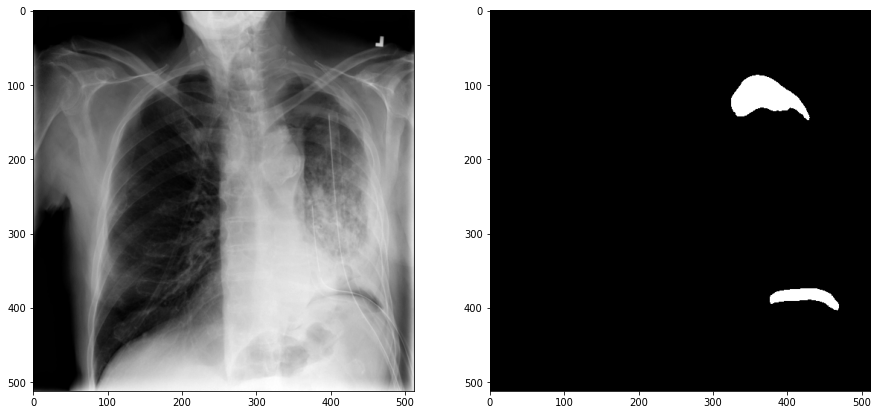

In [243]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 12))

ax1.imshow(image[0, 0, :, :], cmap="gray")
ax2.imshow(mask[0, 0, :, :], cmap="gray")
fig.show()

In [244]:
unet = SegmentationUnet.load_from_checkpoint(checkpoint_path=checkpoint_path)

In [245]:
output = torch.sigmoid(unet(image))

In [246]:
output.shape, mask.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [247]:
criterion = torch.nn.BCELoss()

In [272]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.binary_cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [320]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha])
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none').view(-1)
        targets = targets.type(torch.long)
        print(inputs.device, targets.device)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = ((at*(1-pt))**self.gamma) * BCE_loss
        return F_loss.mean()

In [321]:
criterion_2 = FocalLoss(gamma=2)
criterion_3 = WeightedFocalLoss(gamma=2, alpha=0.25)
criterion_4 = DiceBCELoss()

In [322]:
# print(criterion(output, mask))
# print(criterion_2(output, mask))
criterion_3(output, mask)
# print(criterion_4(output, mask))

cpu cpu


tensor(0.0118, grad_fn=<MeanBackward0>)